In [1]:
import pandas as pd
import numpy as np
import os
import librosa
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt
import pickle

C:\Users\andre\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


### Cose da testare:

- **a che numero secondi tagliare ogni audio**: non sembra cambiare molto che io tagli audio maggiori di 4 secondi o 2.64 (media della durata dei secondi) l'accuracy rimane simile
- **spectogramma in dB o normale**: simile, forse meglio con dB però
- **mfcc**: con mfcc ho provato n_mfcc = 20 e 40 e con entrambe ottengo un'accuracy di circa il 30% mentre con mel spectogram l'acuracy massima raggiunta è di circa il 45%)
- **anzichè droppare tutti i segnali lunghi tagliare porzioni utili di audio lunghi 20 secondi ed aggiungerle a segnali audio brevi**: si può vedere ma avendo visto che le prestazioni non sembrano cambiare molto taglaindo secondi maggiori di 4 o 2.64 secondi non credo migliori molto
- **numero righe e colonne su cui splittare spectogramma**: sembra che sottomatrici più piccole diano risultati leggermente migliori ma comunque poco
- **applicare eventuale denoising** <br/> <br/>
- **IMPORTANTE DA FARE**: secondo me bisognerebbe estrarre la feature del genere perchè voci femminili hanno frequenza maggiore, bisognerebbe creare una feature genere (0: femmina, 1: maschio) insieme alle medie e stds delle sottomatrici perchè magari samples che dicono la stessa cosa sono molto diversi solo perchè magari "turn on the lights" è stato detto da una ragazza che ha frequenza maggiore di un ragazzo e quindi il modello si può confondere (per fare ciò ho letto che bisogna usare il pitch del segnale audio)

### Results
- **Configuration**: <= 4 secondi, spettogramma normale, width_col = 30, width_row = 32 <br/>
  **best hyperparams**: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 50} <br/>
 **accuracy** = 0.43521102951171653 <br/><br/>
 
- **Configuration**: <= 4 secondi, spettogramma dB, width_col = 30, width_row = 32 <br/>
  **best hyperparams**: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 100} <br/>
 **accuracy** = 0.41 <br/> <br/><br/>
 
- **Configuration**: <= 4 secondi, spettogramma dB, width_col = 10, width_row = 16 <br/>
  **best hyperparams**: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 100} <br/>
 **accuracy** =  0.45912102696730256 <br/> <br/><br/>
 
- **Configuration**: <= 2.64 secondi, spettogramma dB, width_col = 10, width_row = 16 <br/>
  **best hyperparams**:  {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 100} <br/>
 **accuracy** =  0.458447821855859 <br/>
 
 




In [2]:
# Hyperparams

n_mfcc = 40

## 1. Loading Dataset

In [3]:
path = r'C:/Users/andre/OneDrive/Documenti/GitHub/winter_exam_22_23/development.csv'
df_development = pd.read_csv(path)
df_development

,Id,path,speakerId,action,object,Self-reported fluency level,First Language spoken,Current language used for work/school,gender,ageRange
0,0,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/0a312...,2BqVo8kVB2Skwgyb,change language,none,advanced,English (United States),English (United States),female,22-40
1,1,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/0ee42...,2BqVo8kVB2Skwgyb,activate,music,advanced,English (United States),English (United States),female,22-40
2,2,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/1d9f3...,2BqVo8kVB2Skwgyb,deactivate,lights,advanced,English (United States),English (United States),female,22-40
3,3,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/269fc...,2BqVo8kVB2Skwgyb,increase,volume,advanced,English (United States),English (United States),female,22-40
4,4,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/5bbda...,2BqVo8kVB2Skwgyb,increase,volume,advanced,English (United States),English (United States),female,22-40
...,...,...,...,...,...,...,...,...,...,...
9849,9849,dsl_data/audio/speakers/vnljypgejkINbBAY/4fb3d...,vnljypgejkINbBAY,decrease,volume,native,English (United States),English (United States),male,22-40
9850,9850,dsl_data/audio/speakers/vnljypgejkINbBAY/59e6a...,vnljypgejkINbBAY,deactivate,lights,native,English (United States),English (United States),male,22-40
9851,9851,dsl_data/audio/speakers/vnljypgejkINbBAY/5c81c...,vnljypgejkINbBAY,deactivate,lights,native,English (United States),English (United States),male,22-40
9852,9852,dsl_data/audio/speakers/vnljypgejkINbBAY/5ef42...,vnljypgejkINbBAY,deactivate,lights,native,English (United States),English (United States),male,22-40


In [4]:
#Evlauate balancement of dataset
df_development.action.value_counts(), df_development.object.value_counts()

(increase           3823
 decrease           3575
 change language    1113
 activate            791
 deactivate          552
 Name: action, dtype: int64,
 volume    5000
 heat      2398
 none      1113
 music      791
 lights     552
 Name: object, dtype: int64)

### Evaluate all the existing combinations in the dataset

In [5]:
#Evaluate all the existing combinations in the dataset
df_increase = df_development[df_development['action']=='increase']
df_increase.object.value_counts()

volume    2614
heat      1209
Name: object, dtype: int64

In [6]:
df_increase

,Id,path,speakerId,action,object,Self-reported fluency level,First Language spoken,Current language used for work/school,gender,ageRange
3,3,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/269fc...,2BqVo8kVB2Skwgyb,increase,volume,advanced,English (United States),English (United States),female,22-40
4,4,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/5bbda...,2BqVo8kVB2Skwgyb,increase,volume,advanced,English (United States),English (United States),female,22-40
6,6,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/6a1cd...,2BqVo8kVB2Skwgyb,increase,heat,advanced,English (United States),English (United States),female,22-40
7,7,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/72160...,2BqVo8kVB2Skwgyb,increase,heat,advanced,English (United States),English (United States),female,22-40
16,16,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/256b2...,2BqVo8kVB2Skwgyb,increase,volume,advanced,English (United States),English (United States),female,22-40
...,...,...,...,...,...,...,...,...,...,...
9829,9829,dsl_data/audio/speakers/Pz327QrLaGuxW8Do/37824...,Pz327QrLaGuxW8Do,increase,heat,native,English (United States),English (United States),female,22-40
9837,9837,dsl_data/audio/speakers/Pz327QrLaGuxW8Do/98546...,Pz327QrLaGuxW8Do,increase,volume,native,English (United States),English (United States),female,22-40
9838,9838,dsl_data/audio/speakers/Pz327QrLaGuxW8Do/a1b55...,Pz327QrLaGuxW8Do,increase,volume,native,English (United States),English (United States),female,22-40
9842,9842,dsl_data/audio/speakers/Pz327QrLaGuxW8Do/1e8a9...,Pz327QrLaGuxW8Do,increase,heat,native,English (United States),English (United States),female,22-40


In [7]:
#Evaluate all the existing combinations in the dataset
df_decrease = df_development[df_development['action']=='decrease']
df_decrease.object.value_counts()

volume    2386
heat      1189
Name: object, dtype: int64

In [8]:
#Evaluate all the existing combinations in the dataset
df_change_language = df_development[df_development['action']=='change language']
df_change_language.object.value_counts()

none    1113
Name: object, dtype: int64

In [9]:
#Evaluate all the existing combinations in the dataset
df_activate = df_development[df_development['action']=='activate']
df_activate.object.value_counts()

music    791
Name: object, dtype: int64

In [10]:
#Evaluate all the existing combinations in the dataset
df_deactivate = df_development[df_development['action']=='deactivate']
df_deactivate.object.value_counts()

lights    552
Name: object, dtype: int64

Combinations of actions expressed by humans in the dataset found are the following:
1. increase volume
2. increase heat
3. decrease volume
4. decrease heat
5. change language
6. activate music
7. deactivate lights

According to this, starting from this dataset a new one can be generated containing the audio file with the corresponding label aside referring to the desired action.

### Creating new training dataset
Add a column called labels where in correspondance of each combination has the respective label (ex. if the row has action=increase and object=heat has label 1)

In [11]:
#df_development_increase_volume = df_development.loc[(df_development['action'] == 'increase') & (df_development['object'] == 'volume')]
df_development['labels']=0

#df_development_increase_volume = df_development.loc[(df_development['action'] == 'increase') & (df_development['object'] == 'volume')]
df_development.loc[(df_development['action'] == 'increase') & (df_development['object'] == 'volume'), 'labels']=1
df_development.loc[(df_development['action'] == 'increase') & (df_development['object'] == 'heat'), 'labels']=2

df_development.loc[(df_development['action'] == 'decrease') & (df_development['object'] == 'volume'), 'labels']=3
df_development.loc[(df_development['action'] == 'decrease') & (df_development['object'] == 'heat'), 'labels']=4

df_development.loc[(df_development['action'] == 'change language') & (df_development['object'] == 'none'), 'labels']=5

df_development.loc[(df_development['action'] == 'activate') & (df_development['object'] == 'music'), 'labels']=6
df_development.loc[(df_development['action'] == 'deactivate') & (df_development['object'] == 'lights'), 'labels']=7

df_development
#df_development.labels.value_counts() #check

,Id,path,speakerId,action,object,Self-reported fluency level,First Language spoken,Current language used for work/school,gender,ageRange,labels
0,0,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/0a312...,2BqVo8kVB2Skwgyb,change language,none,advanced,English (United States),English (United States),female,22-40,5
1,1,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/0ee42...,2BqVo8kVB2Skwgyb,activate,music,advanced,English (United States),English (United States),female,22-40,6
2,2,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/1d9f3...,2BqVo8kVB2Skwgyb,deactivate,lights,advanced,English (United States),English (United States),female,22-40,7
3,3,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/269fc...,2BqVo8kVB2Skwgyb,increase,volume,advanced,English (United States),English (United States),female,22-40,1
4,4,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/5bbda...,2BqVo8kVB2Skwgyb,increase,volume,advanced,English (United States),English (United States),female,22-40,1
...,...,...,...,...,...,...,...,...,...,...,...
9849,9849,dsl_data/audio/speakers/vnljypgejkINbBAY/4fb3d...,vnljypgejkINbBAY,decrease,volume,native,English (United States),English (United States),male,22-40,3
9850,9850,dsl_data/audio/speakers/vnljypgejkINbBAY/59e6a...,vnljypgejkINbBAY,deactivate,lights,native,English (United States),English (United States),male,22-40,7
9851,9851,dsl_data/audio/speakers/vnljypgejkINbBAY/5c81c...,vnljypgejkINbBAY,deactivate,lights,native,English (United States),English (United States),male,22-40,7
9852,9852,dsl_data/audio/speakers/vnljypgejkINbBAY/5ef42...,vnljypgejkINbBAY,deactivate,lights,native,English (United States),English (United States),male,22-40,7


Now to generate a new dataset with recording and corresponding label assigned we need to extract every audio file looking at the path column.

In [12]:
path_working_directory = r'C:/Users/andre/OneDrive/Documenti/GitHub/winter_exam_22_23'
paths_recordings = df_development['path']

Comment the cell below once you have created your pickle file

In [13]:
# signals = []
# sample_rates = []

# for path in paths_recordings:
#     file_path = f'{path_working_directory}/{path}'
    
#     signal, sr = librosa.load(file_path)
    
#     signals.append(signal)
#     sample_rates.append(sr)
    

In [14]:
# labels = df_development['labels']
# df = []
# df.append(paths_recordings)
# df.append(signals)
# df.append(sample_rates)
# df.append(labels)

In [15]:
# df=[]
# name_file = r'/df.pickle'
# print( path_working_directory+name_file)
# with open(path_working_directory+name_file, "wb") as output_file:
#     pickle.dump(df, output_file)

Load pickle file.

In [16]:
name_file = r'/df.pickle'

with open(path_working_directory+name_file, 'rb') as f:
        df = pickle.load(f)
#df


Evaluate the distribution of duration of each audio

<AxesSubplot:title={'center':'Lenght of audios distribution (seconds)'}>

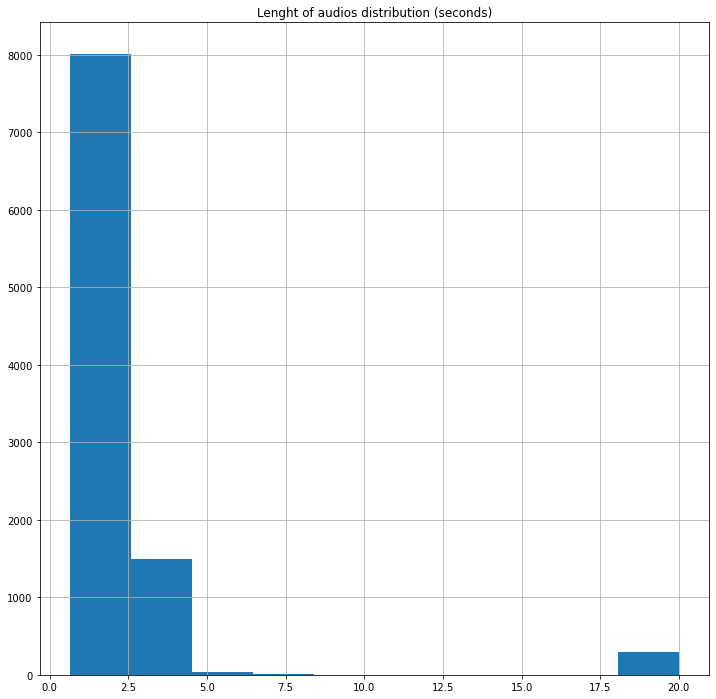

In [17]:
length_audios = []
length_audios_seconds = []
indexes = []
i = 0

for item,sr in zip(df[1], df[2]):
    length_audios.append(len(item))
    length_audios_seconds.append(len(item)/sr)
    if len(item)/sr  <=4:
        indexes.append(i)
    i = i+1
        

length_audios=pd.Series(length_audios)
length_audios_seconds = pd.Series(length_audios_seconds)
#print(length_audios_seconds.value_counts())
plt.figure(figsize=(12,12))
plt.title("Lenght of audios distribution (seconds)")
length_audios_seconds.hist()
#print(length_audios_seconds)


Let's compute the mean of duration of seconds.

In [18]:
np.array(length_audios_seconds).mean()

2.6398029599499635

Retrieve the Mel spectogram and MFCC components of an audio.

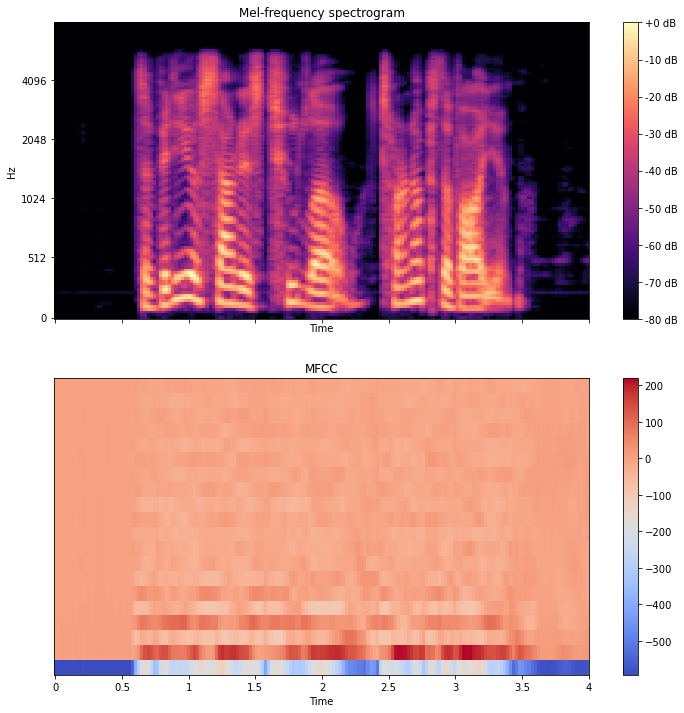

In [19]:
# Mel spectogram
spectogram = librosa.feature.melspectrogram(y=df[1][1752], sr=sr)
S_dB = librosa.power_to_db(spectogram, ref=np.max)

# MFCC
mfcc = librosa.feature.mfcc(y=df[1][1752], sr=sr)

fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(12,12))

# Plotting Mel spectogram
img1 = librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=sr,
                         fmax=8000, ax=ax[0])

fig.colorbar(img1, ax=ax[0], format='%+2.0f dB')
ax[0].set(title='Mel-frequency spectrogram')

img2 = librosa.display.specshow(mfcc, x_axis='time',
                        sr=sr,
                        ax=ax[1])

ax[1].set(title='MFCC')
fig.colorbar(img2, ax=ax[1])


In [20]:
print(mfcc)
print(mfcc.shape)

[[-5.9301764e+02 -5.9295972e+02 -5.9253046e+02 ... -5.8062311e+02
  -5.7907410e+02 -5.7712573e+02]
 [ 0.0000000e+00  7.9693638e-02  6.7038548e-01 ...  1.2609159e+01
   1.6104380e+01  1.9449421e+01]
 [ 0.0000000e+00  7.3164962e-02  6.1545974e-01 ...  2.2146511e+00
   7.6971636e+00  1.1632781e+01]
 ...
 [ 0.0000000e+00 -5.5748038e-02 -4.6895504e-01 ... -6.0941112e-01
  -1.5227859e+00 -3.0791001e+00]
 [ 0.0000000e+00 -4.0373527e-02 -3.3962229e-01 ... -5.7493811e+00
  -4.3048315e+00 -3.2645073e+00]
 [ 0.0000000e+00 -2.2813473e-02 -1.9190873e-01 ... -6.5852218e+00
  -4.6940260e+00 -2.5347922e+00]]
(20, 173)


Check if all the audios have the same sample rate.

In [21]:
s_rates = pd.Series(df[2])
s_rates.value_counts()

22050    9854
dtype: int64

Every signal has the same sample rate of 22050.

In [22]:
sample_rate = 22050

## 2. Pre-Processing

There exist 9464 audio files (-300 of 20 seconds long) whose length is below 4 seconds, since the total of samples is 9857, it seems reasonable to cut take only the files whose length is lower or equal to 4 and then, in order to obtain comparable spectogram matrixes for every audio signal, the signals that present length < 4 are zero padded in the end in order to reach all audio signal of the same length (4) so also the matrices will be of the same size.

In [23]:
length_audios = []
length_audios_seconds = []
indexes_to_drop = []
i = 0

for item,sr in zip(df[1], df[2]):
    length_audios.append(len(item))
    length_audios_seconds.append(len(item)/sr)
    if len(item)/sr >= 2.64:
        indexes_to_drop.append(i)
    i = i+1
        



In [24]:
len(indexes_to_drop)

1761

In [25]:
df_pd = pd.DataFrame({'audio':df[1], 'label':df[3]})
df_pd

,audio,label
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",5
1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",6
2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",7
3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1
4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1
...,...,...
9849,"[0.009223618, 0.010777138, 0.009321626, 0.0099...",3
9850,"[0.00936052, 0.010867924, 0.009305291, 0.00991...",7
9851,"[0.0014334349, 0.001723074, 0.0015384919, 0.00...",7
9852,"[0.009742705, 0.011407773, 0.009794228, 0.0103...",7


In [26]:
df_pd=df_pd.drop(indexes_to_drop).reset_index(drop=True) #reset_index because we have a new df and if we want to iterate over it is simpler
df_pd

,audio,label
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",5
1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",6
2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",7
3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1
4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1
...,...,...
8088,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",4
8089,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",5
8090,"[0.0014619534, 0.0017252679, 0.0015617849, 0.0...",7
8091,"[0.009850104, 0.011306311, 0.009458789, 0.0098...",5


Now retireve the max length of samples characterizing audio file (should be around 4 seconds) in order to pad every other array with lower dimension til the same length in order to have all audio file of the same length.

Check that now the audios have differnt length.

In [27]:
# Find maximum length of the audio in the dataframe
lengths = [len(audio) for audio in df_pd.audio]
# idx = 45 #check
# lengths[idx], len(df_pd.audio.iloc[idx])
lengths = pd.Series(lengths)
#lengths.max() #88064
lengths[lengths == lengths.max()]
lengths.value_counts()[:10]

41395    525
39514    500
45159    493
43278    462
37633    448
35750    434
48923    401
47040    395
52685    338
50804    323
dtype: int64

In [28]:
# Padding shorter audio with 0 samples in order to get all audio files of the same length
max_length = lengths.max()
for i, audio in enumerate(df_pd.audio):
    
    df_pd.audio[i] = np.pad(df_pd.audio[i],(0,max_length- len(df_pd.audio[i])),mode='constant', constant_values=0)

C:\Users\andre\AppData\Local\Temp/ipykernel_11984/3673961515.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pd.audio[i] = np.pad(df_pd.audio[i],(0,max_length- len(df_pd.audio[i])),mode='constant', constant_values=0)


Now all audios should have the same length.

In [29]:
# CHeck if all the audio files have the same lenght now
lengths = [len(audio) for audio in df_pd.audio]
lengths = pd.Series(lengths)
lengths.value_counts()

57390    8093
dtype: int64

Check the dimensions of the MFCC and mel spectogram matrix of a generic audio.

(128, 113) (40, 113)


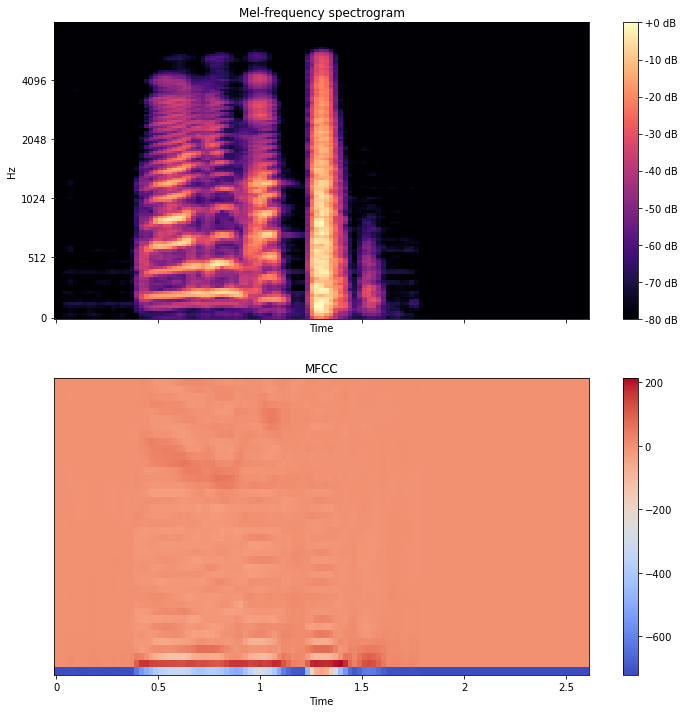

In [30]:
# Mel spectogram
spectogram = librosa.feature.melspectrogram(y=df_pd.audio[3], sr=sr)
S_dB = librosa.power_to_db(spectogram, ref=np.max)

# MFCC
mfcc = librosa.feature.mfcc(y=df_pd.audio[3], sr=sr, n_mfcc=n_mfcc)

fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(12,12))

# Plotting Mel spectogram
img1 = librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=sr,
                         fmax=8000, ax=ax[0])

fig.colorbar(img1, ax=ax[0], format='%+2.0f dB')
ax[0].set(title='Mel-frequency spectrogram')

img2 = librosa.display.specshow(mfcc, x_axis='time',
                        sr=sr,
                        ax=ax[1])

ax[1].set(title='MFCC')
fig.colorbar(img2, ax=ax[1])
print(S_dB.shape, mfcc.shape)

The number of columns is the same for both Mel spectogram and MFCC, while the number of rows differs.

Let's now take the first greater number of columns that can be divided by 10 in order to have more options to easily tune the dimensions of submatrices inside each spectogram.

In [31]:
#Find the first number which can be divided by 10
n_col_dB = S_dB.shape[1]
n_col_mfcc = mfcc.shape[1]

while n_col_dB % 10 != 0:
    n_col_dB = n_col_dB+1

while n_col_mfcc % 10 != 0:
    n_col_mfcc = n_col_mfcc+1
n_col_dB, n_col_mfcc

(120, 120)

Now that every audio signal has the same size and been correctly padded we can compute the spectogram or MFCC matrix for each of them.

In [32]:
last_column_s_db = S_dB[:,-1]
last_column_mfcc = mfcc[:, -1]

In [33]:
np.tile(last_column_s_db,(3,1)).transpose().shape

(128, 3)

In [34]:
spectograms = []
mfccs = []

#Flag variable to indicate if we take the dB scale or not of the spectograms
dB = True
mfcc_comp = True

if dB == True and mfcc_comp == False:
    
    #depending on the ref option in librosa.power_to_db the value to stack has to change
    # np.max = 0
    # np.mean = -55.963474
    tmp =np.tile(last_column_s_db,(n_col_dB-spectogram.shape[1],1)).transpose()
    
    #tmp = np.full((spectogram.shape[0], n-spectogram.shape[1]), 0)
else:
    #the sprectograms obtained for these audios are 128x173 so we add 7 columns of 0 to get 128x180 matrices (<=4 seconds)
    #tmp = np.zeros((spectogram.shape[0], n-spectogram.shape[1]))
    tmp = np.tile(last_column_mfcc,(n_col_mfcc-mfcc.shape[1],1)).transpose()

print(tmp.shape)



for i, audio in enumerate(df_pd.audio):
    
    if mfcc_comp == True:
        spectogram = librosa.feature.mfcc(y=df_pd.audio[i], sr=sr, n_mfcc=n_mfcc)
    else:
        spectogram = librosa.feature.melspectrogram(y=df_pd.audio[i], sr=sr)
    
    if dB == True and mfcc_comp == False: #we are in mel spectogram dB case
        spectogram = librosa.power_to_db(spectogram, ref=np.max)
    
    #adjust spectogram size to get nice number of columns that are easy to divide3
    spectogram= np.hstack((spectogram,tmp))
    
    spectograms.append(spectogram)

(40, 7)


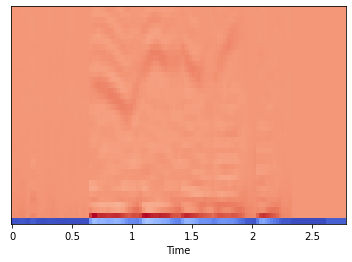

In [35]:
plt.figure()
librosa.display.specshow(spectograms[10], x_axis='time', sr=sr)
plt.show()

In [139]:
# x= spectograms[0].copy()
# tmp = np.zeros((spectograms[0].shape[0], 7))
# x=np.hstack((x,tmp))
# x.shape

In [36]:
df_pd['spectogram'] = spectograms

In [37]:
# fig, ax = plt.subplots()
# img = librosa.display.specshow(df_pd['spectogram'][0], x_axis='time',
#                          y_axis='mel', sr=sr,
#                          fmax=8000, ax=ax)
# fig.colorbar(img, ax=ax, format='%+2.0f dB')
# ax.set(title='Mel-frequency spectrogram')

In [38]:
# fig, ax = plt.subplots()
# img = librosa.display.specshow(df_pd.spectogram[467], x_axis='time',
#                          y_axis='mel', sr=sr,
#                          fmax=8000, ax=ax)
# fig.colorbar(img, ax=ax, format='%+2.0f dB')
# ax.set(title='Mel-frequency spectrogram')

Now that we have obtained the spectogram of same dimension for every audio signal we can procede with the step of feature extraction.

## 3. Feature Extraction

For each spectogram of dimension RxC we need to divide it into a grid of rxc squares, each square will have dimensions R/r and C/c, so r and c will be hyperparameters.

Let's start by choosing r = c.

In [131]:
R, C = df_pd.spectogram[0].shape
nr = 4
nc = 12
width_row =  R//nr #128/8 = 16 -> each square will have height of 16
width_col = C//nc #173/8 = 21.625 -> each square has width of 21.625 

In [132]:
print(R, C)
print(nr, nc)
print(width_row, width_col)

40 120
4 12
10 10


In [133]:
import numpy as np 

# Define the number of rows and columns for each submatrix 
width_rows = width_row 
width_cols = width_col
#df_means_stds = pd
#for audio_spectogram in df_pd.spectogram:
    
data = []


for audio_spectogram in df_pd.spectogram:
    
    means = []
    stds = []

    # Define the original matrix 
    original_matrix = audio_spectogram

    # Divide the original matrix into submatrices 
    submatrices = np.array([original_matrix[i:i+width_rows, j:j+width_cols] for i in range(0, original_matrix.shape[0], width_rows) for j in range(0, original_matrix.shape[1], width_cols)]) 

    for sub in submatrices:
        means.append(sub.max())
        stds.append(sub.std())
    
    row_to_add = means + stds
    data.append(row_to_add)

submatrices.shape


(48, 10, 10)

In [134]:
new_df = pd.DataFrame(data)
new_df

,0,1,2,3,4,5,6,7,8,9,...,86,87,88,89,90,91,92,93,94,95
0,23.023342,121.476395,146.054016,172.662766,153.924301,153.273346,129.091934,90.881119,15.718788,0.000000,...,10.436408,6.691076,20.480892,20.026957,5.931681,2.910642,0.292225,0.000000,0.000000,0.0
1,40.633011,162.819550,134.958679,153.513229,174.090729,106.980194,3.441489,0.000000,0.000000,0.000000,...,13.771959,13.958125,3.550627,1.538104,0.300509,0.000000,0.000000,0.000000,0.000000,0.0
2,69.676941,70.440460,192.672974,258.724121,220.226807,236.541748,100.389664,83.261230,94.589935,0.000000,...,6.092967,12.753291,14.594438,15.646358,4.454166,5.827270,4.927794,0.000000,0.000000,0.0
3,9.978434,167.619751,146.219940,167.461197,179.397827,200.557281,212.996994,19.274040,0.000000,0.000000,...,14.436831,8.601435,12.413073,4.450874,2.516730,1.257061,0.000000,0.000000,0.000000,0.0
4,107.335785,17.968916,39.282291,229.653168,201.257339,230.548462,229.494400,242.026474,279.185242,249.238144,...,0.933769,7.759544,8.835422,12.731001,13.977339,7.172484,2.112955,2.760820,1.569023,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8088,135.278320,167.442535,171.735168,166.954437,169.262543,145.369324,121.860710,0.000000,0.000000,0.000000,...,7.099960,5.661522,5.664399,3.845354,1.659852,0.000000,0.000000,0.000000,0.000000,0.0
8089,128.557373,194.239288,189.228409,184.714294,182.974289,153.580963,110.431625,0.000000,0.000000,0.000000,...,7.804875,6.889943,5.169174,6.430109,4.121876,0.000000,0.000000,0.000000,0.000000,0.0
8090,98.050987,176.333679,221.296555,204.051300,240.776382,155.930115,85.899139,43.246826,44.870880,71.780884,...,8.568662,10.137456,3.092782,3.678174,3.008002,1.777253,2.251027,1.324868,0.393191,0.0
8091,104.858429,68.948532,131.447327,146.917862,180.321228,199.028839,243.067871,101.615936,30.844406,21.958628,...,3.864388,17.821531,7.368906,4.768206,4.537415,3.406325,2.517612,1.316396,1.428850,0.0


In [135]:
new_df['label'] = df_pd.label
new_df

,0,1,2,3,4,5,6,7,8,9,...,87,88,89,90,91,92,93,94,95,label
0,23.023342,121.476395,146.054016,172.662766,153.924301,153.273346,129.091934,90.881119,15.718788,0.000000,...,6.691076,20.480892,20.026957,5.931681,2.910642,0.292225,0.000000,0.000000,0.0,5
1,40.633011,162.819550,134.958679,153.513229,174.090729,106.980194,3.441489,0.000000,0.000000,0.000000,...,13.958125,3.550627,1.538104,0.300509,0.000000,0.000000,0.000000,0.000000,0.0,6
2,69.676941,70.440460,192.672974,258.724121,220.226807,236.541748,100.389664,83.261230,94.589935,0.000000,...,12.753291,14.594438,15.646358,4.454166,5.827270,4.927794,0.000000,0.000000,0.0,7
3,9.978434,167.619751,146.219940,167.461197,179.397827,200.557281,212.996994,19.274040,0.000000,0.000000,...,8.601435,12.413073,4.450874,2.516730,1.257061,0.000000,0.000000,0.000000,0.0,1
4,107.335785,17.968916,39.282291,229.653168,201.257339,230.548462,229.494400,242.026474,279.185242,249.238144,...,7.759544,8.835422,12.731001,13.977339,7.172484,2.112955,2.760820,1.569023,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8088,135.278320,167.442535,171.735168,166.954437,169.262543,145.369324,121.860710,0.000000,0.000000,0.000000,...,5.661522,5.664399,3.845354,1.659852,0.000000,0.000000,0.000000,0.000000,0.0,4
8089,128.557373,194.239288,189.228409,184.714294,182.974289,153.580963,110.431625,0.000000,0.000000,0.000000,...,6.889943,5.169174,6.430109,4.121876,0.000000,0.000000,0.000000,0.000000,0.0,5
8090,98.050987,176.333679,221.296555,204.051300,240.776382,155.930115,85.899139,43.246826,44.870880,71.780884,...,10.137456,3.092782,3.678174,3.008002,1.777253,2.251027,1.324868,0.393191,0.0,7
8091,104.858429,68.948532,131.447327,146.917862,180.321228,199.028839,243.067871,101.615936,30.844406,21.958628,...,17.821531,7.368906,4.768206,4.537415,3.406325,2.517612,1.316396,1.428850,0.0,5


In [136]:
#Check that mean and std are computed correctly
means = []
stds = []

# Define the original matrix 
original_matrix = df_pd.spectogram[0]

# Divide the original matrix into submatrices 
submatrices = np.array([original_matrix[i:i+width_rows, j:j+width_cols] for i in range(0, original_matrix.shape[0], width_rows) for j in range(0, original_matrix.shape[1], width_cols)]) 

for sub in submatrices:
    means.append(sub.max())
    stds.append(sub.std())

row_to_add = means + stds
#row_to_add
means

[23.023342,
 121.476395,
 146.05402,
 172.66277,
 153.9243,
 153.27335,
 129.09193,
 90.88112,
 15.718788,
 0.0,
 0.0,
 0.0,
 8.190616,
 18.380428,
 9.921371,
 20.139503,
 14.051605,
 18.740273,
 22.84299,
 18.677858,
 3.9552715,
 0.0,
 0.0,
 0.0,
 4.8614483,
 35.522076,
 55.43015,
 15.60113,
 8.963179,
 2.5337887,
 10.742357,
 10.826779,
 1.1219695,
 0.0,
 0.0,
 0.0,
 5.9851255,
 14.391786,
 16.671637,
 29.358353,
 52.49791,
 49.63797,
 21.180573,
 8.153365,
 1.6262851,
 0.0,
 0.0,
 0.0]

## 4. Training and Validation

In [137]:
y = new_df['label']
X = new_df.drop(columns='label')
seed = 42

In [138]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
X_train.shape, X_test.shape, y_train.shape, y_test.shape 

((6474, 96), (1619, 96), (6474,), (1619,))

In [139]:
### RandomForest Classifier ###
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

def randforest_classifier(input_x, input_y, cv=10, seed = seed):
    ## Defining parameters
    model_RF= RandomForestClassifier(random_state =seed)

    parameters = {'n_estimators':[100], 
                  'criterion':['gini', 'entropy'],
                  'max_features':['sqrt', 'log2']}

    ## Building Grid Search algorithm with cross-validation and Mean Squared Error score.

    grid_search_RF = GridSearchCV(estimator=model_RF,  
                         param_grid=parameters,
                         scoring='accuracy',
                         cv=cv,
                         n_jobs=-1,
                        verbose = 15)

    ## Lastly, finding the best parameters.

    grid_search_RF.fit(input_x, input_y)
    best_parameters_RF = grid_search_RF.best_params_  
    best_score_RF = grid_search_RF.best_score_ 
    print(best_parameters_RF)
    print(best_score_RF)
    results = grid_search_RF.cv_results_
    
    return best_parameters_RF, results

best_params, RF_CV_results = randforest_classifier(X_train, y_train, 10, seed)

Fitting 10 folds for each of 4 candidates, totalling 40 fits
{'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 100}
0.34754565229835704


In [140]:
best_params

{'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 100}

## Esperimenti a caso

In [ ]:
# frame = 1024
# hop = frame//2 #integer division


In [ ]:
# df[2]
# s_rate=pd.Series(df[2])
# s_rate.value_counts()

for item,sr in zip(df[1], df[2]):
    print(item, sr)
    break

In [ ]:
index = 23#34#1#36#126        
#length_audios[length_audios==150000]
df[1][index]
print(df[3][index])
print(len(df[1][index]))
path_audio = df_development.path[index]
path_working_directory+'/'+path_audio
ipd.Audio(path_working_directory+'/'+path_audio)

In [ ]:
length_audios.loc[(length_audios<=50000)]# & (length_audios<=100000)]


In [ ]:
df[1][1]

In [ ]:
len(indexes)

Trying to visualize signals of different classes to see if there exist common patterns.

In [ ]:
df_development[df_development['labels']==5].head()

In [ ]:
# index, label
#3,  1
#4,  1
#6,  2
#7,  2
#5,  3
#26, 3
#8,  4
#9,  4
#0,  5
#47, 5
#1,  6
#12, 6
#2,  7
#15, 7
plt.figure(figsize=(10, 12))

plt.subplot(3,1,1)
librosa.display.waveshow(df[1][8140], alpha=0.5)
plt.subplot(3,1,2)
librosa.display.waveshow(df[1][15], alpha=0.5)

# x = np.linspace(0, 10 - 2 * delta, 200) + delta
# fig, axs = plt.subplots(3, 7, figsize=(15,30), constrained_layout=True)
# for ax in axs:
#     ax.plot(x,df[1][3])

# plt.subplot(3,2,1)
# librosa.display.waveshow(df[1][6], alpha=0.5)
# plt.subplot(3,2,2)
# librosa.display.waveshow(df[1][7], alpha=0.5)
# small_df = []
# small_df.append(df[1][4])
# small_df

## 3.  Feature Extraction

In [ ]:
spectogram = librosa.feature.melspectrogram(y=df[1][36], sr=sr)
spectogram.shape

In [ ]:
spectogram = librosa.feature.melspectrogram(y=df[1][8140], sr=sr)

fig, ax = plt.subplots()
S_dB = librosa.power_to_db(spectogram, ref=np.max)
img = librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=sr,
                         fmax=8000, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram')

In [ ]:
df_spectogram = pd.DataFrame(spectogram)
df_spectogram.shape



In [ ]:
def compute_mean_std_spectogram(spectogram, R, C):
    
    
    
    for i in range(len(R)):
        for j in range(len(C)):
            

## 4. Classification